In [1]:
#import libraries
from DiscoverData import DiscovData
from DataPreparation import DataPreparation

from DLModeling import Modeling
from MLModeling import DecisionTreeModel
from MLModeling import LogisticRegressionModel

import pandas as pd # For DataFrame and handling
import seaborn as sns # High level plotting

#to split the dataset into random train and test subsets
from sklearn.model_selection import train_test_split

#NLP
import nltk
#from textblob import TextBlob

#Keras
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Modeling
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout
 

In [2]:
#Loading data
#https://www.kaggle.com/wcukierski/enron-email-dataset
emails = pd.read_csv('emails.csv', skiprows = lambda x:x%5)


In [4]:
#to see how emails look like
print(emails['message'][0])



Message-ID: <30922949.1075863688243.JavaMail.evans@thyme>
Date: Thu, 31 Aug 2000 05:07:00 -0700 (PDT)
From: phillip.allen@enron.com
To: greg.piper@enron.com
Subject: Re: Hello
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Greg Piper
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Let's shoot for Tuesday at 11:45.  


In [5]:
#object of class DataPreparation
prep = DataPreparation(emails)

#to extract emails' body then add it to a new column
emails['Email'] = prep.bodyExtraction(emails['message'])

#labeling, adding label to each column.
emails['Sentiment'] = prep.labeling(emails['Email'])

#creating a separate dataset with just two columns body and sentiment
df = prep.newData(emails['Email'], emails['Sentiment'])


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103480 entries, 0 to 103479
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Email      103480 non-null  object
 1   Sentiment  103480 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [7]:
#after extracting the body
print(df['Email'][0])

Let's shoot for Tuesday at 11:45.  


In [9]:
#split into train test sets
X = df['Email'] #Extracting data attributes
y = df['Sentiment'] # Extracting target/class labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [10]:
# Create an object of DiscovData class inside DiscoverData.py file.
dis = DiscovData(df)

In [11]:
# To figure out the target distribution
dis.targDistribut(y_train)

normal      29741
joy         23313
anger       15358
sadness      7691
fear         1125
love          350
surprise       32
Name: Sentiment, dtype: int64

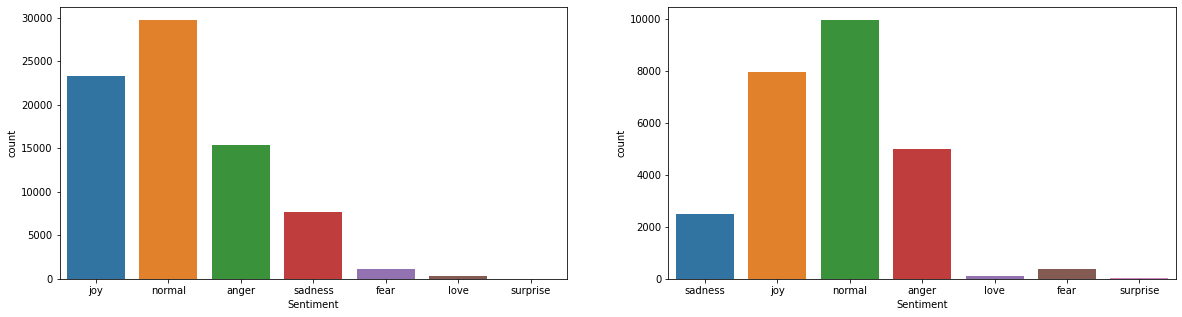

In [12]:
# to plot training and testing data 
dis.sentimentPlolt(y_train, y_test)

In [13]:
# to find missing values:
dis.isNan()

Email        0
Sentiment    0
dtype: int64

In [14]:
# print head
dis.firstObs()

,Email,Sentiment
0,Let's shoot for Tuesday at 11:45.,normal
1,---------------------- Forwarded by Phillip K ...,joy
2,"Dave, \n\n Here are the names of the west desk...",normal
3,---------------------- Forwarded by Phillip K ...,normal
4,"Liane,\n\n As we discussed yesterday, I am con...",fear


In [15]:
#statistics:
dis.discoverData(X_train)

,0
count,77610.000000
mean,1823.649813
std,6067.931719
min,1.000000
25%,287.000000
50%,775.000000
75%,1763.000000
max,820853.000000


In [16]:
#Sentiment Analysis Preparing 
#Using The tokenizer Class to convert the sentences into word vectors

tokenizer=Tokenizer(199431,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X_train)
len(tokenizer.word_index)

# training preparation:
Xtrain =  tokenizer.texts_to_sequences(X_train)

#truncate and pad the input sequences so that they are all the same length for modeling
X_train_pad = pad_sequences(Xtrain, maxlen=80, padding='post')

ytrain = y_train.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5, 'normal':6})
Ytrain= ytrain.values

#One hot Encoding the Emotion Values
Y_train_f=to_categorical(Ytrain) #Converts a class vector (integers) to binary class matrix.

# valedation preparation:
ytest= y_test.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5, 'normal':6})
X_val_f=tokenizer.texts_to_sequences(X_test)
#truncate and pad the input sequences so that they are all the same length for modeling
X_val_pad=pad_sequences(X_val_f, maxlen=80, padding='post')
Y_val_f=to_categorical(ytest)

In [17]:
#Deep Learning
dModel = Modeling(df)
hist = dModel.LSTM(X_train_pad,Y_train_f, X_val_pad,Y_val_f)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48506, 64)         12798272  
_________________________________________________________________
dropout (Dropout)            (None, 48506, 64)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 48506, 160)        92800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               410880    
_________________________________________________________________
dense (Dense)                (None, 7)                 2247      
Total params: 13,304,199
Trainable params: 13,304,199
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
2426/2426 [==============================] - 1246s 511ms/step - loss: 1.0162 - accuracy: 0.5995

In [18]:
dModel.predict(tokenizer, str(input('Enter a sentence : ')))

The emotion predicted is joy


In [19]:
#Machain Learning
mModelDT = DecisionTreeModel(df)
mModelDT.model(X_train_pad, Y_train_f, X_val_pad, Y_val_f)

(('Accuracy Score on train data: ', 0.963355237727097),
 ('Accuracy Score on test data: ', 0.6024739080015462))

In [ ]:
mModelDT.modelHp(X_train_pad, Y_train_f, X_val_pad, Y_val_f)

In [ ]:
mModelLR = LogisticRegressionModel(df)
mModelLR.model(X_train_pad, ytrain, X_val_pad, ytest)

In [ ]:
mModelLR.modelHp(X_train_pad, ytrain, X_val_pad, ytest)